#### Importing Computer Vision Libraries

In [205]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

import time


In [206]:
device = "cuda" if torch.cuda.is_available() else 'cpu'

#### Preparing the data

In [207]:
#training data

train_data = datasets.FashionMNIST(root='data', train= True, transform= ToTensor(), download= True)
test_data = datasets.FashionMNIST(root='data', train= False, transform= ToTensor(), download= True)

In [208]:
print(f" the length of training data is {len(train_data)}, length of test data  { len(test_data)}")

 the length of training data is 60000, length of test data  10000


In [209]:
#visualize any image randomly
img, label = train_data[2]
img, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0863, 0.4627, 0.0941, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.1882, 0.3451, 0.0196, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0471, 0.3922, 0.8314, 0.8039, 0.7255, 0.7020, 0.6784, 0.7294,
           0.7569, 0.8667, 0.5569, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.3333, 0.2980, 0.7804, 0.8824, 0.9725, 1.0000, 0.9333,
           0.8863, 0.6157, 0.2667, 0.3137, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.3569, 0.2706, 0.3569, 0.7882, 0.8549, 0.8824, 0.8196,
           0.6196, 0.2392, 0.3647, 0.2824, 

In [210]:
classnames = train_data.classes
classnames

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

(-0.5, 27.5, 27.5, -0.5)

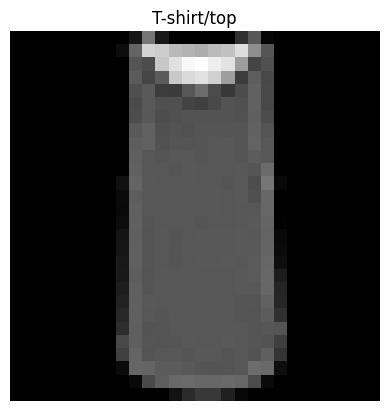

In [211]:
#visualize the image

plt.imshow(img.squeeze(), cmap="gray")
plt.title(classnames[label])
plt.axis(False)



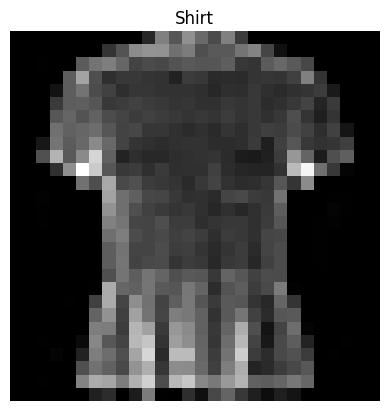

In [212]:
#multiple random images
torch.manual_seed(42)
fig  = plt.Figure(figsize=(9,9))
rows, cols = 4, 4

for i in range(1, rows*cols +1):
    #pick image randomly
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap = 'gray')
    plt.axis(False)
    plt.title(classnames[label])

In [213]:
#dataloader to loop through the dataset

#hyperparameter
BATCH_SIZE = 32

train_data_batch = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle= True )

test_data_batch = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle= False)

print(f" The reduced training databatch is {len(train_data_batch)}")
print(f" The reduced test databatch is {len(test_data_batch)}")

 The reduced training databatch is 1875
 The reduced test databatch is 313


In [214]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_data_batch))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

#### Creating a baseline model

In [215]:
class FashionMNISTVO(nn.Module):
    def __init__(self, input_shape: int, hidden_layers: int,  output_shape: int):
        super().__init__()

        self.linear_stack = nn.Sequential( nn.Flatten(),
                                          nn.Linear(in_features= input_shape, out_features= hidden_layers),
                                          nn.Linear(in_features= hidden_layers, out_features= output_shape),
                                          )
        

    #define the forward method
    def forward(self, x):
        return self.linear_stack(x)

In [216]:
#create a model for the class

model_0 = FashionMNISTVO(input_shape= 784,
                         hidden_layers= 10,
                         output_shape=len(classnames)).to('cpu')

model_0

FashionMNISTVO(
  (linear_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

#### Setup loss, optimizer and evaluation metrics

In [217]:
#loss function

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr = 0.1)

In [218]:
#import helper functions

import requests
from pathlib import Path

r = requests.get(url='https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')

if Path("helper_functions.py").is_file():
    print(" Skipping the download the file already exists")
else:
    print('Downloading file...........')

    with open('helper_functions.py', 'wb') as f:

        f.write(r.content)

 Skipping the download the file already exists


In [219]:
#time function

def my_run_time(start_time, end_time):

    return f" the elapsed time is { end_time - start_time} seconds"
    

In [220]:
from tqdm.auto import tqdm

#set the manual seed
torch.manual_seed(42)
#set the timer
start_time = time.time()

#set the epochs
epochs = 3

for epoch in tqdm(range(epochs)):

    print(f" this is epoch number {epoch}")

    train_loss = 0

    for batch, (X,y) in enumerate(train_data_batch):

        #train model
        model_0.train()

        #do the forward pass
        y_train_pred = model_0(X)

        #calculate the loss
        loss = loss_fn(y_train_pred, y)
        train_loss += loss

        #zero gradient

        optimizer.zero_grad()

        #loss backward
        loss.backward()

        #optimze step
        optimizer.step()

        if batch % 500 == 0:
            print(f"the batches checked are {batch * len(X)}")

        train_loss /= len(train_data_batch)

        #testing

        test_loss, acc = 0, 0

    model_0.eval()

    with torch.inference_mode():

            #do forward pass

        for batch, (X,y) in enumerate(test_data_batch):
                #do the forward pass
            y_test = model_0(X)

                #calculate the loss
            t_loss = loss_fn(y_test, y)
            test_loss += t_loss

        test_loss /= len(test_data_batch)

    print(f" the training loss is {train_loss:.6f}        <||||     test loss {test_loss:.6f}")

end_time = time.time()


print(my_run_time(start_time, end_time))

  0%|          | 0/3 [00:00<?, ?it/s]

 this is epoch number 0
the batches checked are 0
the batches checked are 16000
the batches checked are 32000
the batches checked are 48000


 33%|███▎      | 1/3 [00:07<00:15,  7.52s/it]

 the training loss is 0.000230        <||||     test loss 0.508077
 this is epoch number 1
the batches checked are 0
the batches checked are 16000
the batches checked are 32000
the batches checked are 48000


 67%|██████▋   | 2/3 [00:15<00:07,  7.57s/it]

 the training loss is 0.000315        <||||     test loss 0.481833
 this is epoch number 2
the batches checked are 0
the batches checked are 16000
the batches checked are 32000
the batches checked are 48000


100%|██████████| 3/3 [00:24<00:00,  8.30s/it]

 the training loss is 0.000161        <||||     test loss 0.478955
 the elapsed time is 24.903162717819214 seconds


#### Adding Non-Linearity to our Model


In [221]:
class FashionMNISTV1(nn.Module):

    def __init__(self, input_shape: int, hidden_layers : int, output_shape: int ):
        super().__init__()

        self.linear_stacktwo = nn.Sequential( nn.Flatten(),
                                             nn.Linear(in_features= input_shape, out_features= hidden_layers),
                                             nn.ReLU(),
                                             nn.Linear(in_features=hidden_layers, out_features= output_shape),
                                             nn.ReLU())
        

    def forward(self, x: torch.Tensor):
        return self.linear_stacktwo(x)
        

In [222]:
#instantiate the class

model_1 = FashionMNISTV1(input_shape=784,
                         hidden_layers= 10,
                         output_shape=len(classnames)).to(device='cpu')

model_1

FashionMNISTV1(
  (linear_stacktwo): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

#### Loss function and Accuracy metrics

In [223]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model_1.parameters(), lr = 0.1)



#### functionalizing the testing and training loop

In [224]:
def training_step(model: torch.nn.Module,
                  optimizer: torch.optim.Optimizer,
                  loss: torch.nn.Module,
                  dataloader: torch.utils.data.DataLoader,
                  device: torch.device = device):
    

    model.to(device)

    train_acc, train_loss = 0, 0

    for batch, (X,y) in enumerate(dataloader):

        model.train()

        #do the forward pass

        y_pred = model(X)

        #calculate the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss

        #optimizer

        optimizer.zero_grad()

        #loss backward
        loss.backward()

        #optimizer step
        optimizer.step()

        if batch % 440 == 0:

            print(f"the train loss is {train_loss:.5f}     || ")

    
    

In [225]:
def test_step(model: torch.nn.Module,
                  
                  loss_fn: torch.nn.Module,
                  dataloader: torch.utils.data.DataLoader,
                  device: torch.device = device):
    model.to(device)

    model.eval()
    test_loss = 0

    #loop through the dataset data

    with torch.inference_mode():

        for batch, (X,y) in enumerate(dataloader):

            #forwward pass

            y_test = model(X)

            #calculate the loss

            loss = loss_fn(y_test, y)
            test_loss += loss

            if batch % 440 == 0:
                print(f"the test loss is {test_loss:.5f}     || ")

           


In [226]:
#run a loop through all the data 

start_time = time.time()

epochs = 3

for epoch in tqdm(range(epochs)):

    #training data
    training_step(model=model_1,
                  optimizer= optimizer,
                  loss = loss_fn,
                  dataloader=train_data_batch,
                  device= 'cpu' )
    
    test_step(model= model_1,
              loss_fn= loss_fn,
              dataloader= test_data_batch,
              device= 'cpu')


end_time = time.time()

print(my_run_time(start_time, end_time))

  0%|          | 0/3 [00:00<?, ?it/s]

the train loss is 2.31190     || 
the train loss is 647.48639     || 


### Convolutional Neural Network

In [ ]:
class FashionMNISTV2(nn.Module):
    #class constructor
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels= input_shape,
                      out_channels= hidden_units,
                      kernel_size= 3,
                      stride= 1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d( in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= 2))
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels= hidden_units,
                      out_channels= hidden_units,
                      kernel_size= 3,
                      stride= 1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d( in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= 2)            

        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= hidden_units*7*7, out_features= len(classnames), )
        )

    def forward(self, x):

        x = self.conv_block_1(x)

        x = self.conv_block_2(x)

        x = self.classifier(x)

        return x